In [ ]:
from google.colab import driev

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/archive.zip" -d /content/

Archive:  /content/drive/My Drive/archive.zip
  inflating: /content/test.csv       
  inflating: /content/test_data_v2/0016e1d72d404fe68074cc87cb30aa37.jpg  
  inflating: /content/test_data_v2/002cbbdc87f0484db60ed0c261c53e7b.jpg  
  inflating: /content/test_data_v2/0030624722ae447b98cd36e9c734fce4.jpg  
  inflating: /content/test_data_v2/0065d47a13fc4608a55be23d02a0f523.jpg  
  inflating: /content/test_data_v2/007b141831394b01bfe01fde0a250f6d.jpg  
  inflating: /content/test_data_v2/007b6ae9e88442d39e8c3b641c83ebd8.jpg  
  inflating: /content/test_data_v2/007debdc3b5a4dabbdc1ae39910fde0a.jpg  
  inflating: /content/test_data_v2/0083ffc856f6499ba393482e6e5da58c.jpg  
  inflating: /content/test_data_v2/00a7575f19a544379a8abdd210a2858b.jpg  
  inflating: /content/test_data_v2/00b58c0c3f0747a097b0a438acaeecb1.jpg  
  inflating: /content/test_data_v2/00b85d9e52d14d949ccfd3828c66b592.jpg  
  inflating: /content/test_data_v2/00bb1c734976491e8e8fc2cbe4e4e38d.jpg  
  inflating: /content/test_d

In [ ]:
import pandas as pd

# Load CSV file
csv_path = "/content/test.csv"
df = pd.read_csv(csv_path)

#Display the first few rows
df.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [ ]:
# Step 4: Check dataset statistics
import pandas as pd
import os

# Correct the paths to point to where the dataset was actually extracted
train_images = "/content/train_data/"
test_images = "/content/test_data_v2/"
image_extensions = (".jpg")

total_train_data = len([f for f in os.listdir(train_images) if f.lower().endswith(image_extensions)])
total_test_data = len([f for f in os.listdir(test_images) if f.lower().endswith(image_extensions)])
print(f"Total train images: {total_train_data}")
print(f"Total test images: {total_test_data}")

Total train images: 79950
Total test images: 5540


In [ ]:
# Load CSV file
csv_path = "/content/train.csv"
df = pd.read_csv(csv_path)
label_counts = df['label'].value_counts()
print(f"Number of Real images: {label_counts.get(0, 0)}")
print(f"Number of AI-generated images: {label_counts.get(1, 0)}")

Number of Real images: 39975
Number of AI-generated images: 39975


In [ ]:
# Step 5: Organize dataset into separate folders
import shutil

train_folder = "/content/train"
real_images_folder = os.path.join(train_folder, "real")
ai_generated_folder = os.path.join(train_folder, "ai_generated")

os.makedirs(real_images_folder, exist_ok=True)
os.makedirs(ai_generated_folder, exist_ok=True)

for _, row in df.iterrows():
    filename = os.path.basename(row['file_name'])
    src_path = os.path.join(train_images, filename)
    dest_folder = real_images_folder if row['label'] == 0 else ai_generated_folder
    dest_path = os.path.join(dest_folder, filename)
    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)
    else:
        print(f"Warning: {filename} not found in {train_images}")

print("Dataset organized successfully!")

Dataset organized successfully!


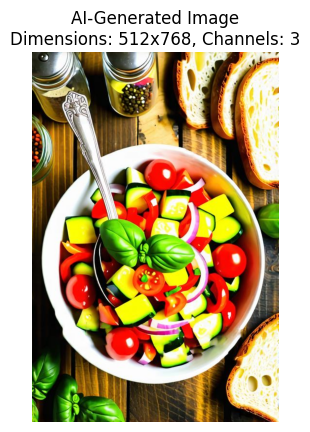

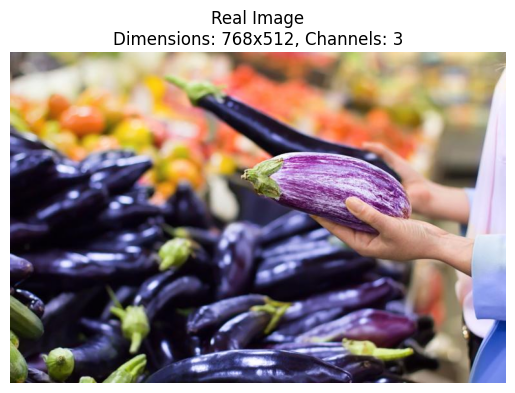

In [ ]:
import cv2 #for displaying images
import matplotlib.pyplot as plt
import os

# Define paths
ai_folder = "/content/train/ai_generated"
real_folder = "/content/train/real"

# Select an AI-generated image
ai_image_name = os.listdir(ai_folder)[100]  # Pick the first AI-generated image
ai_image_path = os.path.join(ai_folder, ai_image_name)

# Select a real image
real_image_name = os.listdir(real_folder)[100]  # Pick the first real image
real_image_path = os.path.join(real_folder, real_image_name)

# Function to show image and dimensions
def show_image(image_path, title):
    image = cv2.imread(image_path)  # Load image using OpenCV (BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display
    height, width, channels = image.shape  # Get dimensions

    # Display image
    plt.imshow(image)
    plt.title(f"{title}\nDimensions: {width}x{height}, Channels: {channels}")
    plt.axis("off")  # Hide axes
    plt.show()

# Show AI-generated image
show_image(ai_image_path, "AI-Generated Image")

# Show Real image
show_image(real_image_path, "Real Image")


In [ ]:
# Step 6: Load images with ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

In [ ]:
# Step 7: Define EfficientNetB0 Model
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation
from tensorflow.keras.models import Model

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-10:]:  # Unfreeze last 10 layers
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256)(x)  # Add a Dense layer with 256 units
x = Activation('relu')(x)  # Apply ReLU activation
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
# print model summary
model.summary();


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 4,335,741 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max")

# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust based on performance
    steps_per_epoch=20000 // BATCH_SIZE,  # Only use 1000 samples
    callbacks=[early_stopping, model_checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 638s 448ms/step - accuracy: 0.8664 - loss: 0.3007 - val_accuracy: 0.5329 - val_loss: 2.1717
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 570s 456ms/step - accuracy: 0.9493 - loss: 0.1344 - val_accuracy: 0.8176 - val_loss: 0.3825
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 532s 426ms/step - accuracy: 0.9682 - loss: 0.0849 - val_accuracy: 0.5179 - val_loss: 2.3495
Epoch 4/10
 248/1250 ━━━━━━━━━━━━━━━━━━━━ 4:09 249ms/step - accuracy: 0.9801 - loss: 0.0623

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 274s 219ms/step - accuracy: 0.9753 - loss: 0.0695 - val_accuracy: 0.6783 - val_loss: 0.6973
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 553s 422ms/step - accuracy: 0.9749 - loss: 0.0646 - val_accuracy: 0.8494 - val_loss: 0.3312
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 529s 423ms/step - accuracy: 0.9797 - loss: 0.0547 - val_accuracy: 0.7862 - val_loss: 0.4527
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 530s 425ms/step - accuracy: 0.9830 - loss: 0.0462 - val_accuracy: 0.7579 - val_loss: 0.5157
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 272s 218ms/step - accuracy: 0.9789 - loss: 0.0502 - val_accuracy: 0.7094 - val_loss: 0.6417


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# After training your model
model.save('/content/drive/MyDrive/my_trained_model.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/my_trained_model.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 432 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# After training your model (e.g., using model.fit())
model.save('my_trained_model.keras')

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import os # Import the os module
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load the trained model
model = tf.keras.models.load_model('my_trained_model.keras')

def predict_image(image_path, model):
    """Predicts the class of an image using the given model."""
    # Check if the file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    img = cv2.imread(image_path)  # Load the image

    # Check if the image was loaded correctly
    if img is None:
        raise IOError(f"Error loading image: {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))  # Resize to match model input size
    img = image.img_to_array(img)  # Convert to array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = preprocess_input(img)  # Preprocess the image

    # Make prediction
    prediction = model.predict(img)
    return prediction[0][0]  # Get the probability

# Path to the single image you want to predict
image_path = '/content/3.jpeg'

# Get the prediction, handling potential errors
try:
    prediction = predict_image(image_path, model)
    print(prediction)
    # Interpret the prediction
    if prediction < 0.5:
        print("The image is likely Real.")
    else:
        print("The image is likely AI-Generated.")
except FileNotFoundError as e:
    print(f"Error: {e}")  # Print the FileNotFoundError message
except IOError as e:
    print(f"Error: {e}")  # Print the IOError message

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
0.47821775
The image is likely Real.


In [ ]:
from tensorflow import keras

# When you want to use the model again:
model = keras.models.load_model('my_trained_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 432 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_image(image_path, model):
    # Check if the image file exists before reading it
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    img = cv2.imread(image_path)

    # Check if the image was loaded successfully
    if img is None:
        raise IOError(f"Error loading image: {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize to match EfficientNet input
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    prediction = model.predict(img)
    return prediction[0][0]

# Load your trained model
model = tf.keras.models.load_model("best_model.keras")

# Path to your image
image_path = "/content/unnamed.png"

# Get prediction
try:
    prediction = predict_image(image_path, model)
    # Interpret prediction
    if prediction < 0.5:
        print("The image is likely Real.")
    else:
        print("The image is likely AI-Generated.")
except FileNotFoundError as e:
    print(f"Error: {e}")
except IOError as e:
    print(f"Error: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
The image is likely Real.


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_image(image_path, model):
    """Predicts the class of an image using the given model."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        raise IOError(f"Error loading image: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    prediction = model.predict(img)
    return prediction[0][0]

# Load your trained model
model = tf.keras.models.load_model("best_model.keras")

# Path to your test dataset
test_images_dir = "/content/test_data_v2/"

# Limit to 100 images
image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))][:100]

correct_predictions = 0
total_predictions = 0

for filename in image_files:
    image_path = os.path.join(test_images_dir, filename)
    try:
        prediction = predict_image(image_path, model)

        # Assuming you have ground truth labels (e.g., in a CSV file),
        # replace 'ground_truth_label' with how you get the actual label for the image.
        ground_truth_label = 0  # Example: Assuming all test images are real (label 0)

        if (prediction < 0.5 and ground_truth_label == 0) or (prediction >= 0.5 and ground_truth_label == 1):
            correct_predictions += 1
        total_predictions += 1

    except (FileNotFoundError, IOError) as e:
        print(f"Error processing {filename}: {e}")

accuracy = correct_predictions / total_predictions
print(f"Accuracy on 100 test images: {accuracy * 100:.2f}%")

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step